In [6]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [7]:
video = cv2.VideoCapture('../project_skl/data/Subject0/10kg_top/video.mp4')

print(video.get(cv2.CAP_PROP_FRAME_COUNT))
round(video.get(cv2.CAP_PROP_FPS))

0.0


0

In [8]:
pose_seq = np.load('../project_skl/data/Subject0/10kg_top/pose3d.npy')

FileNotFoundError: [Errno 2] No such file or directory: '../project_skl/data/Subject0/10kg_top/pose3d.npy'

In [11]:
with open('../project_skl/data/Subject0/10kg_top/pose2d.json', 'rb') as rb:
    pose2d = json.load(rb)

In [30]:
df = pd.read_csv('../project_skl/data/Subject0/10kg_top/raw_emg.csv', skiprows=60)

time_column = df.iloc[:, 0]
emg_signal = df.iloc[:, 1:]
emg_signal

,Avanti sensor 2: EMG 2 [V],Avanti sensor 4: EMG 4 [V],Avanti sensor 6: EMG 6 [V],Avanti sensor 7: EMG 7 [V],Avanti sensor 8: EMG 8 [V],Avanti sensor 10: EMG 10 [V],Avanti sensor 11: EMG 11 [V],Avanti sensor 15: EMG 15 [V]
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
347971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
347972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
347973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
347974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
def resample_emg_rms(csv_path, output_path, num_video_frames):
    # Read the CSV file
    try:
        df = pd.read_csv(csv_path)
    except:
        df = pd.read_csv(csv_path, skiprows=60)

    # Assume the first column is time or indices, and the rest are EMG channels
    time_column = df.iloc[:, 0]
    emg_signal = df.iloc[:, 1:]  # Remaining columns are EMG channels
    
    # Calculate the step size and ensure it matches the target frame count
    step_size = len(df) / num_video_frames

    # RMS downsampling with fixed window
    resampled_data = []
    for col in emg_signal.columns:
        channel_data = emg_signal[col].values
        channel_data -= channel_data.mean()
        
        rms_values = []
        for frame_idx in range(num_video_frames):
            # Calculate the window for the current frame
            center = int(frame_idx * step_size)
            start = max(0, int(center - step_size // 2))
            end = min(len(channel_data), int(center + step_size // 2))

            # Compute RMS for the window
            window = channel_data[start:end]
            rms = np.sqrt(np.mean(window ** 2))
            rms_values.append(rms)

        resampled_data.append(rms_values)

    # Generate new time indices based on video FPS
    new_time_indices = np.linspace(0, time_column.iloc[-1], num_video_frames)

    # Combine the resampled channels into a DataFrame
    resampled_df = pd.DataFrame(np.array(resampled_data).T, columns=emg_signal.columns)
    resampled_df.insert(0, 'Time', new_time_indices)

    # Save the resampled DataFrame to a new CSV file
    resampled_df.to_csv(output_path, index=False)
    print(f"Resampled EMG data saved to {output_path}")

csv_path = '../project_skl/data/Subject0/10kg_move/raw_emg.csv'
output_path = './resampled_emg_rms_fixed.csv'
# original_sampling_rate = 2.148148e+003
# video_fps = video.get(cv2.CAP_PROP_FPS)
video = cv2.VideoCapture('../project_skl/data/Subject0/10kg_move/video.mp4')
num_video_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

resample_emg_rms(csv_path, output_path, num_video_frames)

Resampled EMG data saved to ./resampled_emg_rms_fixed.csv


In [229]:
data = []

train_path = './datasplit/train'
for file in os.listdir(train_path):
    with open(os.path.join(train_path, file), 'r') as r:
        lines = r.readlines()
    
    subject_info_keys = ['age', 'height', 'weight', 'muscle', 'fat', 'arm_len', 'leg_len', 'load']
    subject_info_values = np.array([[24, 174, 70.1, 27.8, 20.3, 25.5, 39.5],
                           [23, 177, 67.0, 30.0, 13.4, 28.0, 40.0],
                           [24, 169, 69.6, 32.0, 13.5, 28.0, 40.5],
                           [23, 175, 94.0, 35.5, 31.5, 26.5, 39.5],
                           [20, 183, 86.9, 36.7, 21.8, 29.0, 42.5],
                           [25, 173, 70.0, 35.0, 15.4, 26.0, 40.0],
                           [25, 173, 77.4, 37.4, 12.6, 26.0, 42.5], 
                           [25, 169, 68.0, 29.1, 15.7, 25.0, 40.0], 
                           [24, 174, 83.2, 37.2, 18.0, 25.0, 40.0], 
                           [25, 170, 62.3, 25.3, 16.9, 26.0, 36.0],
                           [25, 180, 106.8, 49.3, 21.8, 25.0, 40.0],
                           [23, 170, 56.2, 29.5, 4.3, 25.0, 40.0],
                           [24, 173, 68.1, 32.7, 10.5, 26.0, 37.0],
                           [24, 176, 79.2, 35.6, 16.7, 26.0, 40.0],
                           [23, 176, 67.8, 30.4, 13.9, 26.0, 40.0],
                           [23, 166, 52.7, 25.4, 7.1, 24.0, 38.0]])
    
    scaler = StandardScaler()
    scaler.fit(subject_info_values)

    for _ in lines:
        x = {}
        filepath = _.strip('\n')
        x['filename'] = filepath
        x['subject'] = filepath.split('/')[2]

        x['subject_info'] = subject_info_values[0]
        weight = x['subject_info'][2]
        load = int(filepath.split('/')[3].split('kg')[0]) / weight
        x['subject_info'] = np.append(scaler.transform(subject_info_values[0].reshape(1, -1)), np.array([load]))

        x['pose3d'] = np.load(f'{filepath}/pose3d.npy')
        x['emg'] = np.load(f'{filepath}/emg_values.npy', allow_pickle=True)
        
        data.append(x)
        
data[0]['filename'], data[0]['subject'], data[0]['subject_info'], data[0]['pose3d'].shape, data[0]['emg'].shape, len(data)

('./dataset/Subject5/5kg_move/0',
 'Subject5',
 array([ 0.2       ,  0.08936332, -0.2687777 , -0.92046907,  0.72470169,
        -0.44611344, -0.13667809,  0.07132668]),
 (80, 17, 3),
 (80, 7),
 193)

In [1]:
import wandb
import torch
import pytorch_lightning as pl
from tqdm import tqdm
from lightning.pytorch import loggers as pl_loggers
from data_module import DataModule
from args import args
from net.P2M_vanilla import Pose2Muscle
from utils.utils import initialize_model
import matplotlib.pyplot as plt
from torchmetrics import R2Score, MeanAbsolutePercentageError

dm = DataModule(args)
dm.setup()
train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

model = Pose2Muscle(args)
train_loader.dataset[0][3].shape

Number of data loaded in memory: 6308
Number of data loaded in memory: 1532
Number of data loaded in memory: 1532


torch.Size([80, 7])

In [2]:
checkpoint = torch.load('/home/tako/mesrwi/Pose2Muscle/lightning_logs/fnvro7yz/checkpoints/epoch=99-step=19800.ckpt')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

Pose2Muscle(
  (pose_embedding): PoseEmbedding(embedding_dim=128, input_dim=51)
  (encoder): TransformerEncoder(
    (pe): PositionalEncoding()
    (emb_dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (layer_norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (src_src_att): MultiHeadedAttention(
          (k_layer): Linear(in_features=128, out_features=128, bias=True)
          (v_layer): Linear(in_features=128, out_features=128, bias=True)
          (q_layer): Linear(in_features=128, out_features=128, bias=True)
          (output_layer): Linear(in_features=128, out_features=128, bias=True)
          (softmax): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (layer_norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (pwff_layer): Sequential(
            (0): Linear(in_features=128, out_features=20

In [3]:
pose_list = []
pred_list = []
emg_values = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        filename, subject, pose3d, emg = batch
        pose_list.append(pose3d)
        pred_list.append(model(pose3d, subject))
        emg_values.append(emg)

pose_list = torch.cat(pose_list)
preds = torch.cat(pred_list)
emg_values = torch.cat(emg_values)

100%|██████████| 48/48 [01:57<00:00,  2.45s/it]


In [4]:
num_valid = len(preds)
r2_scores = torch.zeros((num_valid, 1))
mape = torch.zeros((num_valid, 1))

for b in range(num_valid):
    for i in range(1):
        r2_scores[b, i] = R2Score()(preds[b, :, i], emg_values[b, :, i])
        mape[b, i] = MeanAbsolutePercentageError()(preds[b, :, i], emg_values[b, :, i])
        
r2_scores.shape, mape.shape

(torch.Size([1532, 1]), torch.Size([1532, 1]))

In [73]:
emg_values.mean(), preds.mean()

(tensor(3.3605), tensor(4.4529))

./dataset/Subject0/5kg_ground/33
R2 tensor([-9.1037]) tensor(-9.1037)
mape tensor([1.0386])


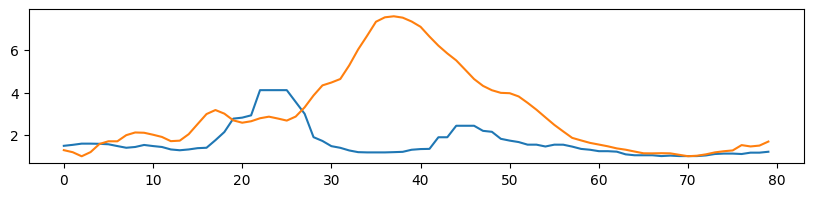

In [ ]:
plt.figure(figsize=(10,2))
b = 10
print(test_loader.dataset[b][0])
print('R2', r2_scores[b], r2_scores[b].mean())
print('mape', mape[b])

plt.plot(emg_values[b, :, :])
plt.plot(preds[b, :, :])
# plt.ylim(0, 100)

In [5]:
r2_scores.mean(axis=0)

tensor([-229.9330])

./dataset/Subject0/5kg_ground/33
R2 tensor([-9.1037]) tensor(-9.1037)
mape tensor([1.0386])


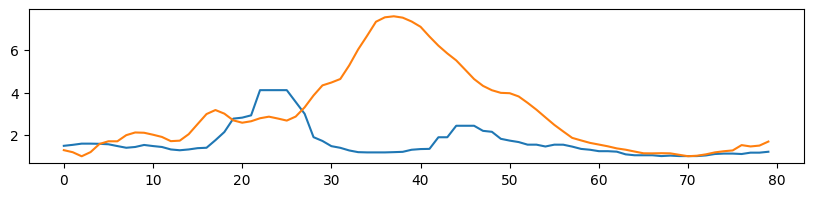

In [70]:
plt.figure(figsize=(10,2))
b = 10
print(test_loader.dataset[b][0])
print('R2', r2_scores[b], r2_scores[b].mean())
print('mape', mape[b])

plt.plot(emg_values[b, :, :])
plt.plot(preds[b, :, :])
# plt.ylim(0, 100)

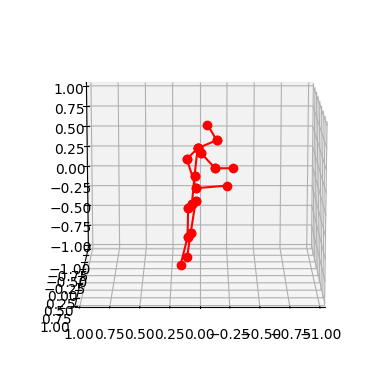

In [24]:
from utils.plot3d import visualization

visualization('/home/tako/mesrwi/Pose2Muscle/dataset/Subject11/10kg_top/11/pose3d.npy', 'r2_-29.mp4')

In [127]:
import numpy as np
from scipy.fftpack import dct, idct

x_coord = pose3d[:, 3, 1]

dct_coef = dct(x_coord, norm='ortho')

n = 16
filtered_dct_coef = np.zeros_like(dct_coef)
filtered_dct_coef[:n] = dct_coef[:n]

x_reconstructed = idct(filtered_dct_coef, norm='ortho')
x_reconstructed

array([0.9601247 , 0.9598826 , 0.9594358 , 0.9588515 , 0.9582141 ,
       0.95760834, 0.9571036 , 0.9567414 , 0.9565287 , 0.95644057,
       0.9564283 , 0.95643413, 0.9564066 , 0.9563137 , 0.9561492 ,
       0.9559313 , 0.9556925 , 0.9554659 , 0.95526993, 0.95509803,
       0.9549173 , 0.9546764 , 0.95432186, 0.95381755, 0.95316046,
       0.952389  , 0.951578  , 0.9508213 , 0.95020664, 0.949791  ,
       0.9495818 , 0.949533  , 0.94955766, 0.94955456, 0.94944143,
       0.949184  , 0.94881254, 0.94841784, 0.9481277 , 0.9480681 ,
       0.948322  , 0.9488969 , 0.9497138 , 0.950621  , 0.95143235,
       0.95197946, 0.9521621 , 0.95198286, 0.9515537 , 0.9510703 ,
       0.95076036, 0.95081866, 0.9513477 , 0.95232165, 0.95358336,
       0.9548791 , 0.9559199 , 0.9564564 , 0.9563441 , 0.95558214,
       0.95431566, 0.9528005 , 0.9513413 , 0.95021766, 0.94962233,
       0.9496246 , 0.9501676 , 0.95109886, 0.95222193, 0.95335305,
       0.95436645, 0.95521516, 0.9559249 , 0.9565645 , 0.95720

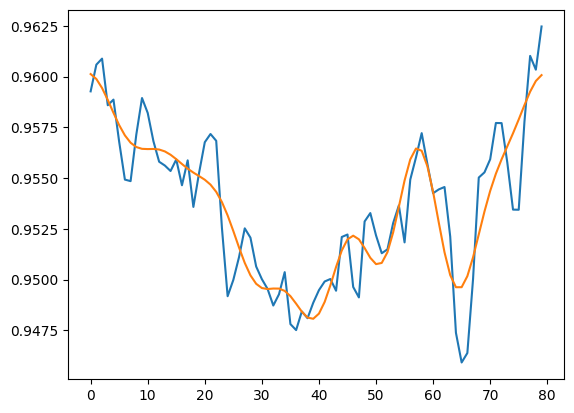

In [128]:
plt.plot(x_coord)
plt.plot(x_reconstructed)

/tmp/ipykernel_1033069/3410568008.py:1: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(dct_coef, use_line_collection=True)


<StemContainer object of 3 artists>

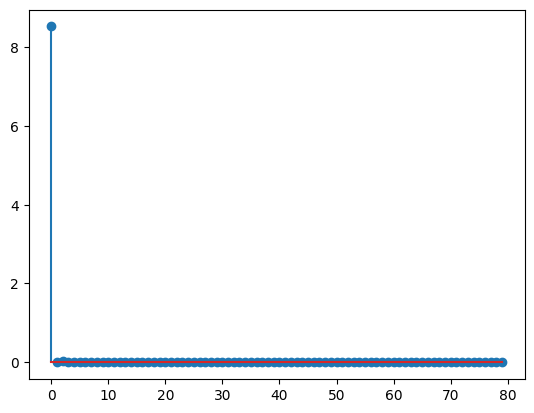

In [132]:
plt.stem(dct_coef, use_line_collection=True)

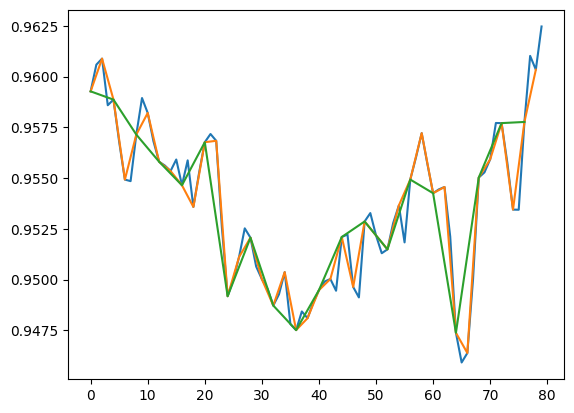

In [93]:
import numpy as np

pose3d = np.load('/home/tako/mesrwi/Pose2Muscle/dataset/Subject11/10kg_top/11/pose3d.npy', allow_pickle=True)
plt.plot(pose3d[:, 3, 1][::1])#, marker='o')
plt.plot(range(0, 80, 2), pose3d[:, 3, 1][::2])#, marker='o')
plt.plot(range(0, 80, 4), pose3d[:, 3, 1][::4])#, marker='o')

In [2]:
args['target_muscle'] = ['ES', 'UT', 'BB', 'FDS', 'ED', 'BF', 'VL']

dm = DataModule(args)
dm.setup()
train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

model = Pose2Muscle(args)

checkpoint = torch.load('/home/tako/mesrwi/Pose2Muscle/lightning_logs/kno3w07b/checkpoints/epoch=299-step=59400.ckpt')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

all_pose_list = []
all_pred_list = []
all_emg_values = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        filename, subject, pose3d, emg = batch
        all_pose_list.append(pose3d)
        all_pred_list.append(model(pose3d, subject))
        all_emg_values.append(emg)

all_pose_list = torch.cat(all_pose_list)
all_preds = torch.cat(all_pred_list)
all_emg_values = torch.cat(all_emg_values)

num_valid = len(all_preds)
all_r2_scores = torch.zeros((num_valid, 7))
all_mape = torch.zeros((num_valid, 7))

for b in range(num_valid):
    for i in range(len(args['target_muscle'])):
        all_r2_scores[b, i] = R2Score()(all_preds[b, :, i], all_emg_values[b, :, i])
        all_mape[b, i] = MeanAbsolutePercentageError()(all_preds[b, :, i], all_emg_values[b, :, i])
        
all_r2_scores.shape, all_mape.shape

Number of data loaded in memory: 6308
Number of data loaded in memory: 1532
Number of data loaded in memory: 1532


100%|██████████| 48/48 [01:46<00:00,  2.22s/it]


(torch.Size([1532, 7]), torch.Size([1532, 7]))

In [5]:
all_r2_scores.mean()

tensor(-5.3420)

R2 tensor([[ 0.1040,  0.2850,  0.3588,  0.3998,  0.3571,  0.2703,  0.9140],
        [ 0.5310, -2.0608,  0.7760,  0.7857, -0.6450,  0.9288,  0.9453],
        [ 0.3776,  0.4497,  0.4045,  0.3343,  0.5240,  0.8192,  0.9662],
        [ 0.6139, -0.6906,  0.6578,  0.8501,  0.8061,  0.7040,  0.9189],
        [ 0.5564, -0.8453, -0.2507, -0.3087, -3.3002,  0.1577, -0.1983],
        [ 0.5106,  0.4309,  0.7826,  0.7467,  0.4189, -0.1853, -0.8463],
        [ 0.7601,  0.7279, -0.3115,  0.1234, -1.8586,  0.3060, -0.0452],
        [ 0.7600, -0.1566,  0.6858,  0.8484,  0.0570,  0.4185,  0.1475],
        [ 0.3335,  0.2334,  0.6987,  0.7405, -0.0820, -0.3690,  0.2415],
        [ 0.5552,  0.1434,  0.5625,  0.6734, -0.3349,  0.1989,  0.1615],
        [ 0.4239,  0.4257,  0.8805,  0.7002,  0.0431,  0.1664, -0.3462],
        [-0.1240,  0.5581, -0.2485,  0.2012,  0.1903, -0.0361, -0.0713],
        [ 0.4460,  0.5406,  0.4661,  0.7394,  0.2954, -0.2512,  0.3585],
        [ 0.5570,  0.5566,  0.4449,  0.8623,  0.

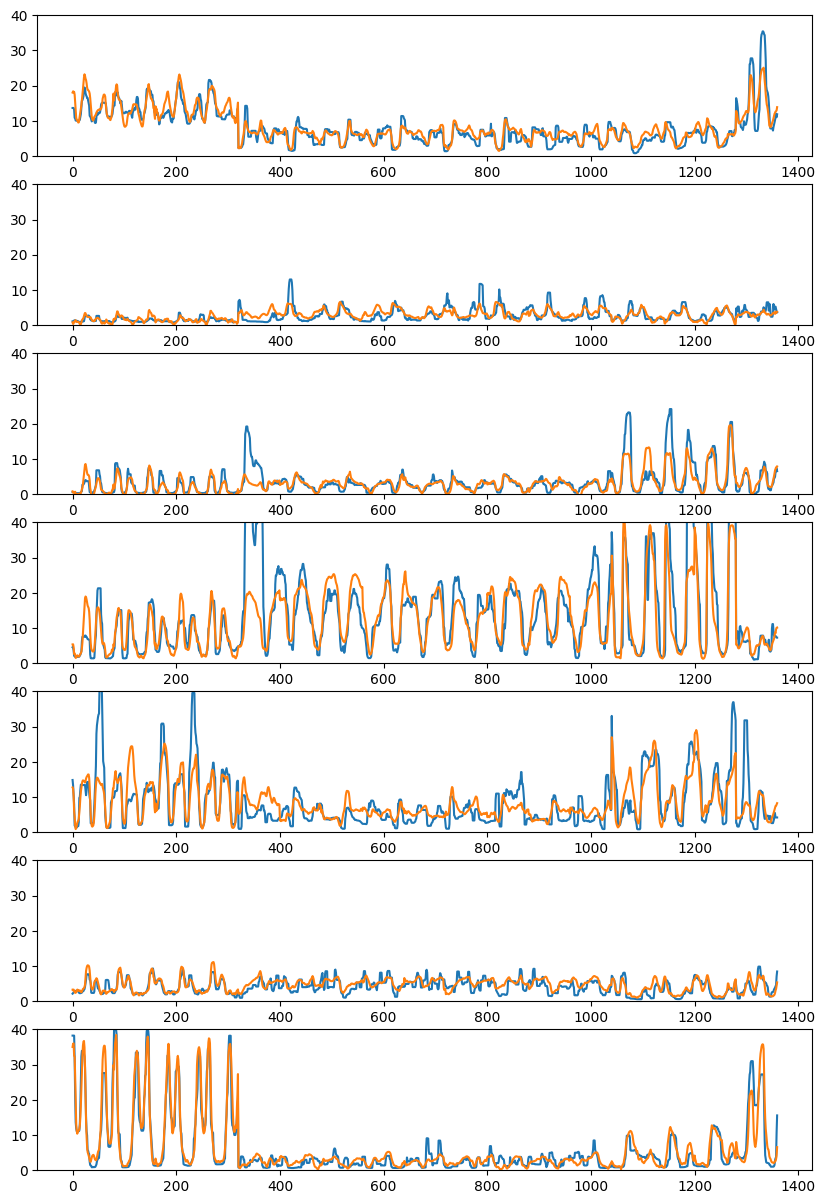

In [17]:
plt.figure(figsize=(10,15))
b = 1243
b_ = 1260
print('R2', all_r2_scores[b:b_], all_r2_scores[b:b_].mean())
print('mape', all_mape[b:b_], all_mape[b:b_].mean())
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(all_emg_values[b:b_, :, i].view(-1, 1))
    plt.plot(all_preds[b:b_, :, i].view(-1, 1))
    plt.ylim(0, 40)

In [47]:
import numpy as np
import torch

muscle_id = {'ES': 0, 'UT': 1, 'BB': 2, 'FDS': 3, 'ED': 4, 'BF': 5, 'VL': 6}

target_muscle = ['BF', 'VL']

emg = torch.Tensor(np.load('/home/tako/mesrwi/Pose2Muscle/dataset/Subject0/5kg_ground/29/emg_values.npy', allow_pickle=True).astype(np.float32))
x = []
for muscle in target_muscle:
    x.append(emg[:, muscle_id[muscle]].unsqueeze(1))

torch.cat(x, dim=1).shape

torch.Size([80, 2])

In [3]:
import torch

torch.stack([torch.randn((32, 80, 7)), torch.randn((28, 80, 7))], dim=0)

RuntimeError: stack expects each tensor to be equal size, but got [32, 80, 7] at entry 0 and [28, 80, 7] at entry 1